ERROR:tvDatafeed.main:error while signin


Total data points after cleaning: 5000
Completed: train_size=2800, seasonal=False, avg_rmse=5.3078
Completed: train_size=3200, seasonal=False, avg_rmse=5.1639
Completed: train_size=3600, seasonal=False, avg_rmse=5.2230
Completed: train_size=4000, seasonal=False, avg_rmse=5.2101
Completed: train_size=4400, seasonal=False, avg_rmse=5.3353

Optimization Results:
   train_size  seasonal  avg_rmse
0        2800     False  5.307850
1        3200     False  5.163940
2        3600     False  5.222953
3        4000     False  5.210066
4        4400     False  5.335323


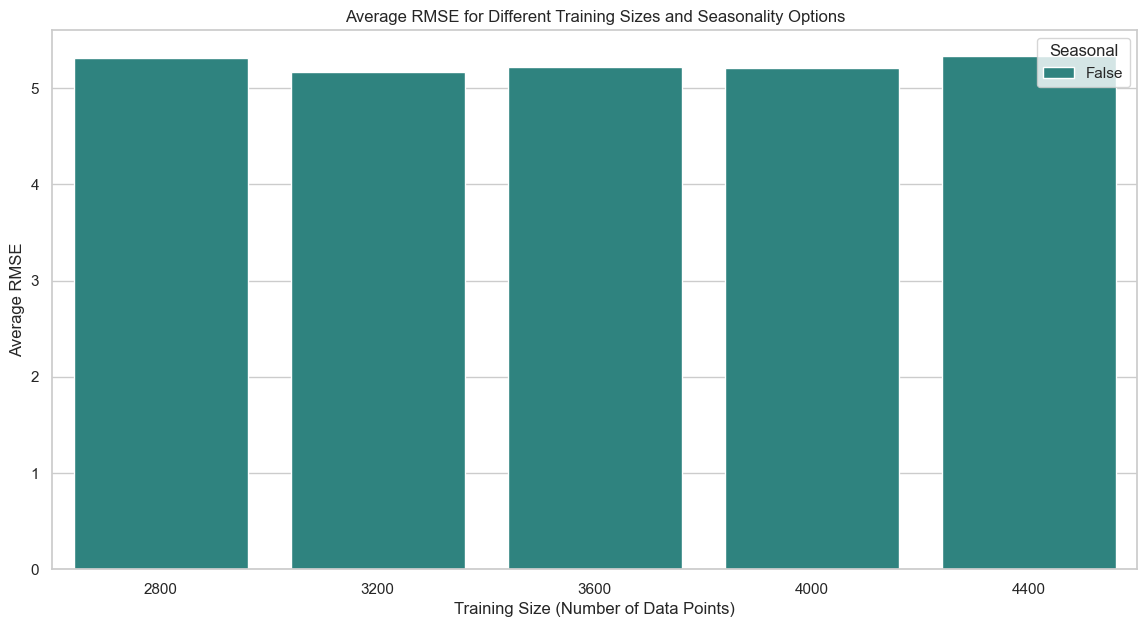

In [3]:
# v2: Changed to 15 minute bars

# ================================
# 1. Data Retrieval and Preparation
# ================================

import os
from dotenv import load_dotenv
from tvDatafeed import TvDatafeedLive, Interval
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
from sklearn.metrics import mean_squared_error
import pmdarima as pm

# Load environment variables from .env file
load_dotenv()

# Retrieve TradingView credentials from environment variables
username = os.environ.get("TRADINGVIEW_USERNAME")
password = os.environ.get("TRADINGVIEW_PASSWORD")

# Initialize TradingView live data feed
tv = TvDatafeedLive(username, password)

# Fetch historical data for XAUUSD (2000 hourly bars)
prices = tv.get_hist(symbol='XAUUSD', exchange='ICMARKETS',
                     interval=Interval.in_15_minute, n_bars=5000)

# Ensure the 'close' column is in numeric format
prices['close'] = pd.to_numeric(prices['close'], errors='coerce')

# Drop any rows with NaN values in 'close'
prices.dropna(subset=['close'], inplace=True)

# Reset index if necessary
prices.reset_index(drop=True, inplace=True)

# Verify total data points after cleaning
total_data_points = prices.shape[0]
print(f"Total data points after cleaning: {total_data_points}")

# ================================
# 2. Hyperparameter Optimization
# ================================

# Define error metric: Root Mean Squared Error (RMSE)
def calculate_rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

# Define optimization parameters
training_sizes = [2800, 3200, 3600, 4000, 4400]    # Number of training data points
seasonal_options = [False]                         # Whether to include seasonality
num_runs = 40                                      # Number of rolling window iterations
forecast_elements = 20                             # Number of data points to forecast (20*15min = 5 hours)
shift_step = 12                                    # Shift each run by 10 data points

# Initialize a list to store results
results = []

# Loop through each combination of training size and seasonality
for train_size in training_sizes:
    for seasonal in seasonal_options:
        rmse_list = []  # To store RMSE for each run
        
        for run in range(num_runs):
            # Define shift for rolling window (0, 10, 20, ..., 290)
            shift = run * shift_step
            
            # Calculate indices for slicing using positive indices
            # start_idx: start of training data
            # end_train_idx: end of training data
            # test_start_idx: start of test data
            # test_end_idx: end of test data
            start_idx = total_data_points - (train_size + forecast_elements + shift)
            end_train_idx = total_data_points - (forecast_elements + shift)
            test_start_idx = end_train_idx
            test_end_idx = end_train_idx + forecast_elements
            
            # Ensure indices are within bounds
            if start_idx < 0 or test_end_idx > total_data_points:
                print(f"Skipping run {run} for train_size={train_size}, seasonal={seasonal} due to insufficient data.")
                continue
            
            # Slice the data for training and testing
            train_prices = prices.iloc[start_idx:end_train_idx]
            test_prices = prices.iloc[test_start_idx:test_end_idx]
            
            # Verify that slicing has the correct number of data points
            if len(train_prices) != train_size or len(test_prices) != forecast_elements:
                print(f"Run {run} failed for train_size={train_size}, seasonal={seasonal}: Incorrect slice sizes. "
                      f"train_size={len(train_prices)}, test_size={len(test_prices)}")
                rmse_list.append(np.nan)
                continue
            
            # Extract the trend component using Savitzky-Golay filter on training data
            try:
                window_length = 19  # Must be a positive odd integer
                polyorder = 1
                if window_length > train_size:
                    print(f"Run {run} failed for train_size={train_size}, seasonal={seasonal}: "
                          f"window_length={window_length} > train_size={train_size}")
                    rmse_list.append(np.nan)
                    continue
                
                trend_train = savgol_filter(train_prices['close'], window_length=window_length, polyorder=polyorder)
            except ValueError as e:
                print(f"Run {run} failed during Savitzky-Golay filter on training data: {e}")
                rmse_list.append(np.nan)
                continue
            
            # Fit Auto-ARIMA model
            try:
                # Define seasonal period based on data frequency
                # For hourly data, daily seasonality m=24
                smodel = pm.auto_arima(
                    trend_train,
                    start_p=1, start_q=1,
                    max_p=4, max_q=4,
                    seasonal=seasonal,
                    m=24 if seasonal else 1,    # Set m=24 for daily seasonality
                    d=None,
                    D=1 if seasonal else 0,
                    trace=False,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=True
                )
                
                # Forecast the next 24 data points (trend_forecast)
                forecast_trend = smodel.predict(n_periods=forecast_elements)
            except Exception as e:
                print(f"Run {run} failed for train_size={train_size}, seasonal={seasonal}: {e}")
                rmse_list.append(np.nan)
                continue
            
            # Extract the actual trend for the test data
            try:
                # Concatenate train and test close prices
                combined_prices = pd.concat([train_prices['close'], test_prices['close']])
                
                # Apply the Savitzky-Golay filter to the combined data
                # Ensure window_length=21 is still valid
                if window_length > len(combined_prices):
                    print(f"Run {run} failed for train_size={train_size}, seasonal={seasonal}: "
                          f"window_length={window_length} > combined_size={len(combined_prices)}")
                    rmse_list.append(np.nan)
                    continue
                
                trend_total = savgol_filter(combined_prices, window_length=window_length, polyorder=polyorder)
                
                # Extract the trend for the test data (last 24 elements)
                trend_test = trend_total[-forecast_elements:]
            except ValueError as e:
                print(f"Run {run} failed during Savitzky-Golay filter on combined data: {e}")
                rmse_list.append(np.nan)
                continue
            
            # Calculate RMSE between forecasted trend and actual test trend
            rmse = calculate_rmse(trend_test, forecast_trend)
            rmse_list.append(rmse)
        
        # Calculate average RMSE across all runs, ignoring NaN values
        avg_rmse = np.nanmean(rmse_list) if rmse_list else np.nan
        
        # Store the results
        results.append({
            'train_size': train_size,
            'seasonal': seasonal,
            'avg_rmse': avg_rmse
        })
        
        print(f"Completed: train_size={train_size}, seasonal={seasonal}, avg_rmse={avg_rmse:.4f}")

# Convert results to DataFrame for analysis
results_df = pd.DataFrame(results)

# Display the results
print("\nOptimization Results:")
print(results_df)

# ================================
# 3. Visualization of Results
# ================================

# Set plot style
sns.set(style="whitegrid")

# Plot Average RMSE for Different Training Sizes and Seasonality Options
plt.figure(figsize=(14, 7))
sns.barplot(x='train_size', y='avg_rmse', hue='seasonal', data=results_df, palette='viridis')
plt.title('Average RMSE for Different Training Sizes and Seasonality Options')
plt.xlabel('Training Size (Number of Data Points)')
plt.ylabel('Average RMSE')
plt.legend(title='Seasonal')
plt.show()
